## Dependencies

In [1]:
!nvidia-smi
!jupyter notebook list
%env CUDA_VISIBLE_DEVICES=3

Thu Dec  5 02:21:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    58W / 149W |   1560MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:00:05.0 Off |                    0 |
| N/A   64C    P8    34W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from models import tiramisu
from models import tiramisu_bilinear
from models import tiramisu_m1
from models import unet
from datasets import deepglobe
from datasets import madg
from datasets import joint_transforms
import utils.imgs
import utils.training as train_utils

# tensorboard
from torch.utils.tensorboard import SummaryWriter

## Dataset

- Download the DeepGlobe dataset from https://competitions.codalab.org/competitions/18467. Place it in datasets/deepglobe/dataset/train,test,valid
- Download the Massachusetts Road Dataset from https://www.cs.toronto.edu/~vmnih/data/. Combine the training, validation, and test sets, process with `crop_dataset.ipynb` and place the output in datasets/maroads/dataset/map,sat
- Run `combine_datasets.ipynb` to combine the two and output to datasets/madg

In [3]:
run = "expM.1.madg.4"
DEEPGLOBE_PATH = Path('datasets/', 'deepglobe/dataset')
MADG_PATH = Path('datasets/', 'madg/dataset')
RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/') / run
RUNS_PATH    = Path('.runs/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)
RUNS_PATH.mkdir(exist_ok=True)

batch_size = 1 # TODO: Should be `MAX_BATCH_PER_CARD * torch.cuda.device_count()` (which in this case is 1 assuming max of 1 batch per card)

In [4]:
# resize = joint_transforms.JointRandomCrop((300, 300))

# normalize = transforms.Normalize(mean=deepglobe.mean, std=deepglobe.std)
# normalize = transforms.Normalize(mean=madg.mean, std=madg.std)
train_joint_transformer = transforms.Compose([
#     resize,
    joint_transforms.JointRandomHorizontalFlip(),
    joint_transforms.JointRandomVerticalFlip(),
    joint_transforms.JointRandomRotate()
    ])

train_dset = madg.Madg(MADG_PATH, 'train',
    joint_transform=train_joint_transformer,
    transform=transforms.Compose([
#         transforms.ColorJitter(brightness=.4,contrast=.4,saturation=.4),
        transforms.ToTensor(),
#         normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=batch_size, shuffle=True)





resize_joint_transformer = None
val_dset = madg.Madg(
    MADG_PATH, 'valid', joint_transform=resize_joint_transformer,
    transform=transforms.Compose([
        transforms.ToTensor(),
#         normalize
    ]))
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

test_dset = madg.Madg(
    MADG_PATH, 'test', joint_transform=resize_joint_transformer,
    transform=transforms.Compose([
        transforms.ToTensor(),
#         normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)

Train: 4771
Val: 1182
Test: 1182
Inputs:  torch.Size([1, 3, 1024, 1024])
Targets:  torch.Size([1, 1024, 1024])


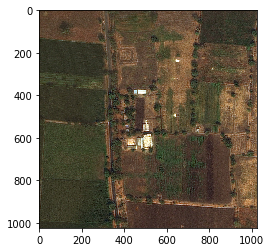

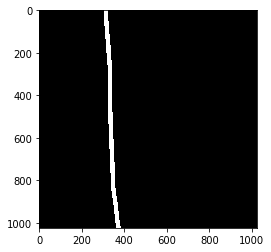

tensor(1.) tensor(0.)
tensor(1, dtype=torch.int32) tensor(0, dtype=torch.int32)


In [5]:
print("Train: %d" %len(train_loader.dataset))
print("Val: %d" %len(val_loader.dataset.imgs))
print("Test: %d" %len(test_loader.dataset.imgs))
# print("Classes: %d" % len(train_loader.dataset.classes))

print((iter(train_loader)))

inputs, targets = next(iter(train_loader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

utils.imgs.view_image(inputs[0])
# utils.imgs.view_image(targets[0])
utils.imgs.view_annotated(targets[0])

print(inputs[0].max(),inputs[0].min())
print(targets[0].max(),targets[0].min())

## Train

In [6]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 1000
torch.cuda.manual_seed(0)

In [7]:
from utils.bceloss import dice_bce_loss
from loss.BCESSIM import BCESSIM

model = tiramisu_m1.FCDenseNetSmall(n_classes=1, dropout_rate=0.2).cuda()

optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)

# criterion = dice_bce_loss()
criterion = BCESSIM()

# summary(model, input_size=inputs[0].shape)

In [8]:
start_epoch = 0
!ls -l {WEIGHTS_PATH/'latest.th'}
start_epoch = train_utils.load_weights(model, (WEIGHTS_PATH/'latest.th')) + 1

print("Starting from epoch", start_epoch)

-rw-r--r-- 1 jupyter jupyter 1329588 Dec  4 02:58 .weights/expM.1.madg.4/latest.th
loading weights '.weights/expM.1.madg.4/latest.th'
loaded weights (lastEpoch 138, loss 0.20503519334461598, error 0.5428047839121815)
Starting from epoch 140


In [9]:
# Writer will output to ./runs/ directory by default
writer = SummaryWriter(log_dir=(RUNS_PATH.as_posix() + "/" + "run" + str(run) + "/"))

In [ ]:
from torch.autograd import Variable

debug_max_size=None

# break # errors. Used to stop "run all"
for epoch in range(start_epoch, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = train_utils.train(
        model, train_loader, optimizer, criterion, epoch, debug_max_size=debug_max_size)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Validation ###
    val_loss, val_err, val_iou = train_utils.test(model, val_loader, criterion, epoch, debug_max_size=debug_max_size)    
    print('Tes - Loss: {:.4f} | Jacc: {:.4f} , Err: {:.4f}'.format(val_loss, val_iou, val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    train_utils.save_weights(model, epoch, val_loss, val_err, WEIGHTS_PATH=WEIGHTS_PATH)

    ### Adjust Lr ###
#     train_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
#                                      epoch, DECAY_EVERY_N_EPOCHS)
    
    # Log on tensorboard
    writer.add_scalar('Loss/train', trn_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    
    writer.add_scalar('Error/train', trn_err, epoch)
    writer.add_scalar('Error/val', val_err, epoch)
    
    writer.add_scalar('Accuracy/train', 1-trn_err, epoch)
    writer.add_scalar('Accuracy/val', val_iou, epoch)

    for param_group in optimizer.param_groups:
        writer.add_scalar('Params/learning_rage', param_group['lr'], epoch)
#     writer.add_scalar('params/learning_rate', optimizer.lr, epoch)
#     writer.add_scalar('Params/no_optim', no_optim, epoch)

    # log a sample image
#     sample_images = [0,1030,281,623,636,655,1028,1353,2222,2224]
    sample_images = [0,1030,281,623,636,655,1028,1000,1001,1002]

    for i in sample_images:
        inputs, targets, pred, loss, err, iou = train_utils.get_sample_predictions(model, val_loader, n=1, criterion=criterion, idx=i)
        raw = model(inputs.cuda()).cpu()        
        img = torchvision.utils.make_grid(torch.stack([
            inputs[0],
            targets[0].unsqueeze(0).expand(3,-1,-1).float(), 
            pred[0].unsqueeze(0).expand(3,-1,-1).float(),
            raw[0].expand(3,-1,-1).float()
        ]), normalize=True)
        
        writer.add_image('sample_pred/val/' + str(i), img, epoch)
    
    start_epoch = epoch

torch.cuda.device_count() 1
multiplier 16.0


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch 140
Train - Loss: 0.1537, Acc: 0.5533
Train Time 43m 44s
Tes - Loss: 0.2100 | Jacc: 0.4441 , Err: 0.5559
Total Time 48m 14s

torch.cuda.device_count() 1
multiplier 16.0
Epoch 141
Train - Loss: 0.1498, Acc: 0.5611
Train Time 44m 22s
Tes - Loss: 0.2076 | Jacc: 0.4441 , Err: 0.5559
Total Time 49m 11s

torch.cuda.device_count() 1
multiplier 16.0
Epoch 142
Train - Loss: 0.1496, Acc: 0.5601
Train Time 42m 58s
Tes - Loss: 0.2064 | Jacc: 0.4425 , Err: 0.5575
Total Time 47m 25s

torch.cuda.device_count() 1
multiplier 16.0



## Debug

In [ ]:
stats = train_utils.view_sample_predictions(model, val_loader, n=1, criterion=criterion)
print("loss", "error", "jaccard")
print(stats)


In [ ]:
# !pip install torchsummary
from torchsummary import summary
summary(model, input_size=inputs[0].shape)